In [95]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [96]:
df_rocrit = pd.read_csv('rocrit_model.csv')
df_stan = pd.read_csv('standard_model.csv')
mapper = {'#Teff(K)': 'Teff', ' Prot(days)': 'Prot', ' Age(Gyr)': 'Age', ' Mass(Msun)': 'Mass'}
df_rocrit.rename(columns=mapper, inplace=True)
df_stan.rename(columns=mapper, inplace=True)

In [97]:
df_rocrit.head()

,Teff,Prot,Age,Mass,Ro
0,3425.943077,3.132252,2.343081,0.39749,0.028923
1,3426.052848,0.769080,1.110579,0.38310,0.007271
2,3429.332363,0.830315,1.162998,0.40312,0.008025
3,3425.867537,1.067847,1.398936,0.39909,0.009989
4,3425.887204,2.477922,2.144391,0.39106,0.022913


In [98]:
df_stan.head()

,Teff,Prot,Age,Mass,Ro
0,3425.943077,3.132252,2.343081,0.39749,0.028923
1,3426.052848,0.769080,1.110579,0.38310,0.007271
2,3429.332363,0.830315,1.162998,0.40312,0.008025
3,3425.867537,1.067847,1.398936,0.39909,0.009989
4,3425.887204,2.477922,2.144391,0.39106,0.022913


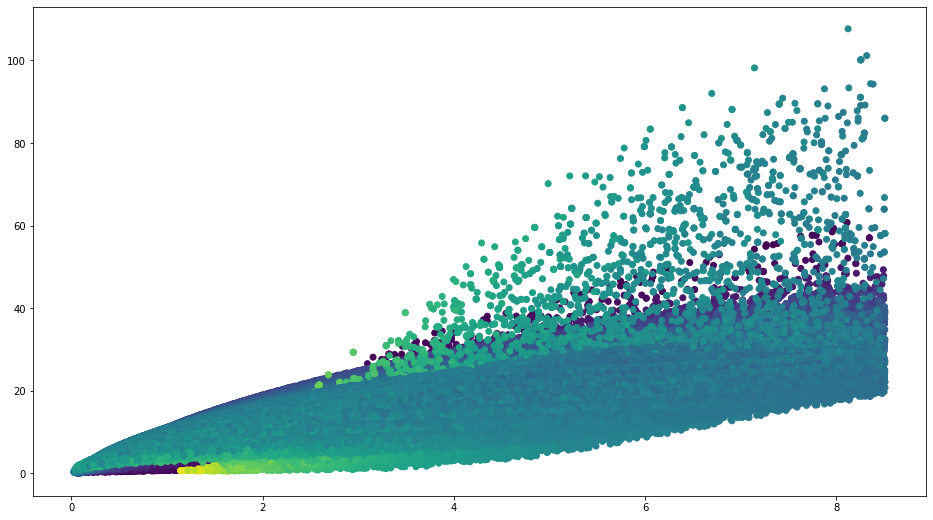

In [99]:
fig, ax = plt.subplots(figsize=[16,9])
ax.scatter(df_rocrit.Age, df_rocrit.Prot, c=df_rocrit.Mass)

In [105]:
print(f'Length of dataset rocrit : {len(df_rocrit)}')
print(f'Length of dataset standard : {len(df_stan)}')

Length of dataset rocrit : 140000
Length of dataset standard : 147875


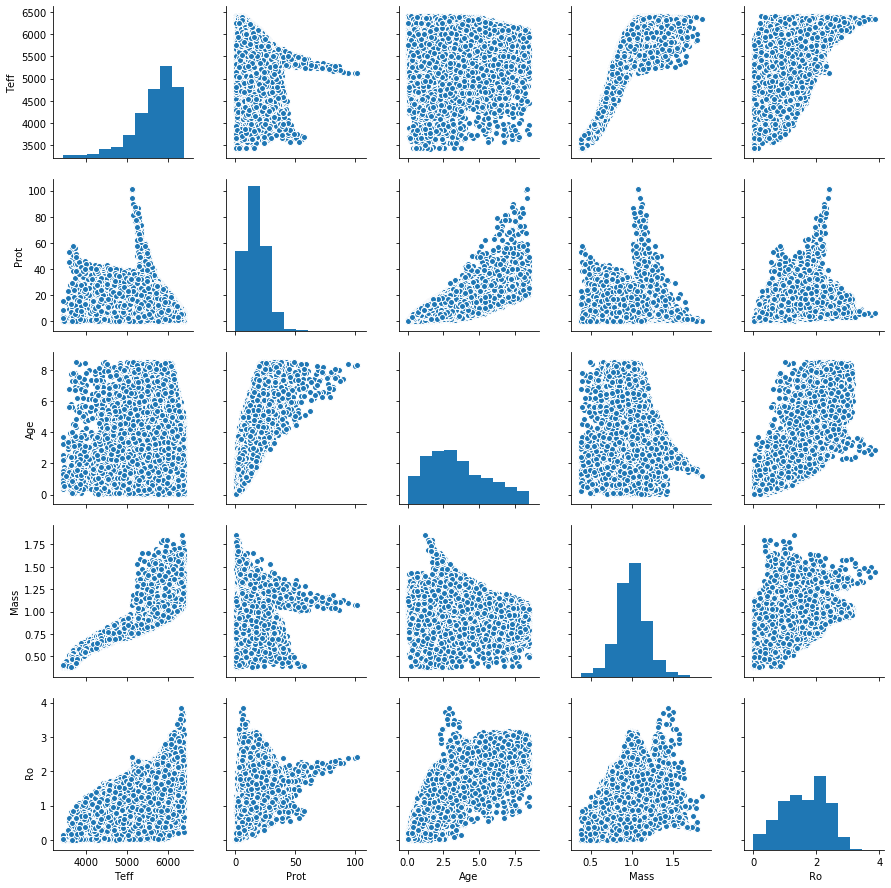

In [101]:
sns.pairplot(df_rocrit.sample(frac=0.1))

In [102]:
import statsmodels.api as sm

In [103]:
bw = np.array([0.02, 10.0, 0.1, 0.2])
dens_rocrit = sm.nonparametric.KDEMultivariate(data=df_rocrit[['Mass', 'Teff', 'Age', 'Prot']].sample(frac=1.0).values, 
                                               var_type='cccc', bw=bw)
dens_stan = sm.nonparametric.KDEMultivariate(data=df_stan[['Mass', 'Teff', 'Age', 'Prot']].sample(frac=1.0).values, 
                                               var_type='cccc', bw=bw)

In [122]:
age = 4.5
prot = np.linspace(20.0, 30.0, 1000)
solar_d_ro = [dens_rocrit.pdf([1.0, 5777.0, age, n]) for n in prot]
solar_d_stan = [dens_stan.pdf([1.0, 5777.0, age, n]) for n in prot]

In [125]:
solar = df_rocrit.loc[np.abs(df_rocrit.Mass - 1.0) < 0.05].loc[np.abs(df_rocrit.Age - age) < 0.2]
solar = solar.loc[np.abs(solar.Teff - 5777.0) < 10.0]

solar_stan = df_stan.loc[np.abs(df_stan.Mass - 1.0) < 0.05].loc[np.abs(df_stan.Age - age) < 0.2]
solar_stan = solar_stan.loc[np.abs(solar_stan.Teff - 5777.0) < 10.0]

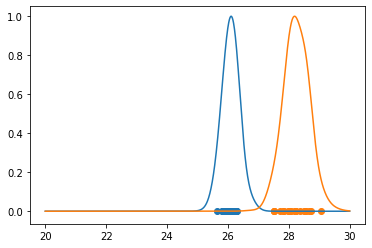

In [126]:
fig, ax = plt.subplots()
ax.scatter(solar.Prot.values, np.zeros(len(solar)))
ax.scatter(solar_stan.Prot.values, np.zeros(len(solar_stan)))
ax.plot(prot, solar_d_ro / np.max(solar_d_ro))
ax.plot(prot, solar_d_stan / np.max(solar_d_stan))
#ax.set_yscale('log')

What about if we train only on a set of stars that look sort of solar?

In [282]:
age = 5.5
solar = df_rocrit.loc[np.abs(df_rocrit.Mass - 1.0) < 0.2].loc[np.abs(df_rocrit.Age - age) < 3.0]
solar = solar.loc[np.abs(solar.Teff - 5777.0) < 300.0]
print(len(solar))
solar_stan = df_stan.loc[np.abs(df_stan.Mass - 1.0) < 0.2].loc[np.abs(df_stan.Age - age) < 3.0]
solar_stan = solar_stan.loc[np.abs(solar_stan.Teff - 5777.0) < 300.0]
print(len(solar_stan))

40603
40603


In [283]:
bw = np.array([0.02, 10.0, 0.1, 0.2])
dens_rocrit = sm.nonparametric.KDEMultivariate(
                data=solar[['Mass', 'Teff', 'Age', 'Prot']].sample(frac=1.0).values, 
                                               var_type='cccc', bw=bw)
dens_stan = sm.nonparametric.KDEMultivariate(
                data=solar_stan[['Mass', 'Teff', 'Age', 'Prot']].sample(frac=1.0).values, 
                                               var_type='cccc', bw=bw)

In [284]:
age = 5.5
prot = np.linspace(20.0, 30.0, 1000)
solar_d_ro = [dens_rocrit.pdf([1.0, 5777.0, age, n]) for n in prot]
solar_d_stan = [dens_stan.pdf([1.0, 5777.0, age, n]) for n in prot]

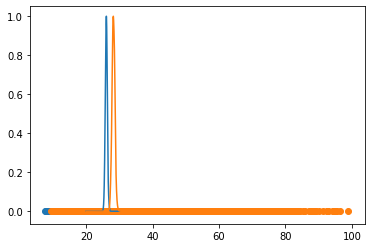

In [285]:
fig, ax = plt.subplots()
ax.scatter(solar.Prot.values, np.zeros(len(solar)))
ax.scatter(solar_stan.Prot.values, np.zeros(len(solar_stan)))
ax.plot(prot, solar_d_ro / np.max(solar_d_ro))
ax.plot(prot, solar_d_stan / np.max(solar_d_stan))
#ax.set_yscale('log')

Now let's try and model a fake star with a mixture ...

In [286]:
params = ['Mass', 'Teff', 'Age', 'Prot', 'P_stan']

class mix_model_like():
    ''' A simple mixture model using KDEs as priors between the models '''
    def __init__(self, dens_stan, dens_rocrit, mass, teff, age, prot):
        self.dens_stan = dens_stan
        self.dens_rocrit = dens_rocrit
        self.teff = teff
        self.mass = mass
        self.age = age
        self.prot = prot

    def prior_standard(self, p):
        return self.dens_stan.pdf(p[:-1])

    def prior_rocrit(self, p):
        return self.dens_rocrit.pdf(p[:-1])

    def ln_normal(self, x, mu, sigma):
        return -0.5 * np.abs(x - mu)**2 / sigma**2

    def likelihood(self, p):
        if (p[-1] > 1.0) or (p[-1] < 0.0):
            return -np.inf        
        like_mix = np.log(1e-30 + p[-1] * self.prior_standard(p) + (1 - p[-1]) * self.prior_rocrit(p))
        like_mix += self.ln_normal(p[0], self.mass[0], self.mass[1])
        like_mix += self.ln_normal(p[1], self.teff[0], self.teff[1])
        like_mix += self.ln_normal(p[2], self.age[0], self.age[1])
        like_mix += self.ln_normal(p[3], self.prot[0], self.prot[1])
        return like_mix

    def __call__(self, p):
        return self.likelihood(p)

In [287]:
like = mix_model_like(dens_stan, dens_rocrit, [1.0, 0.01], [5777.0, 10.0], [5.5, 0.1], [25.4, 0.5])

In [288]:
print(like.prior_standard([1.0, 5777.0, 5.5, 25.2, 0.5]))
print(like.prior_rocrit([1.0, 5777.0, 5.5, 25.2, 0.5]))

3.111378128217031e-11
2.1526468358623254e-05


In [289]:
like([1.0, 5777.0, 4.5, 25.2, 0.9])

-57.41405559383945

In [290]:
import emcee
nwalkers = 32
ndim = 5
sampler = emcee.EnsembleSampler(nwalkers, ndim, like)

In [291]:
p0 = [[1.0, 5777.0, 4.5, 25.2, 0.0] + np.random.rand(ndim) * [0.001, 100, 0.5, 1.0, 1.0] for n in range(nwalkers)]

In [292]:
state = sampler.run_mcmc(p0, 1000)
sampler.reset()

In [298]:
sampler.run_mcmc(state, 2000);

In [299]:
import corner as corner

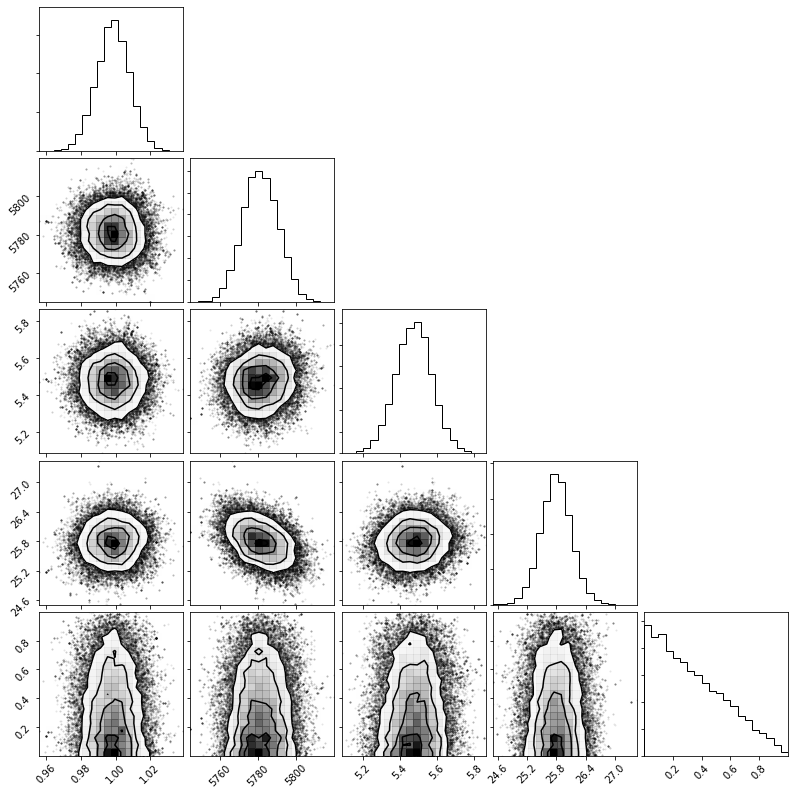

In [300]:
samples = sampler.get_chain(flat=True)
corner.corner(samples);

In [301]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.518


In [302]:
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean autocorrelation time: 50.863 steps
